# Data Science Final Project
by: Christopher Yarbro and Lakeland Galinson


[Link to our github website](https://yarbschris.github.io/ds-final)

## Intro
Our names are Christopher Yarbro and Lakeland Galinson. We are seniors at Tulane University studying Computer Science. This website will host the code, figures, and anything else necessary for our Final Project in Data Science.

**The goal for this project** is to explore geographic crime data in the city of New Orleans. We will aim examine the relationship between crime frequency and type to location and create an interactive visualization showing crime/police reports on a map.

## Research Questions
1. How do reported crimes and 911 calls vary by zoning type across New Orleans?

2. Are commercial or mixed-use zones associated with greater crime density than residential zones?/n

3. Do certain categories of crime (e.g., property, violent, nuisance) appear disproportionately in specific zoning areas?

These questions will guide both exploratory visualizations and later statistical testing in our final tutorial.

## Organization
Our first step was to create a git repository hosted on github that we can both access and edit. We are roommates, so we have been able to meet regularly to discuss our plans for the project.



## Data Sets

### New Orleans Police Department Calls for Service 2025
This dataset, provided by the Orleans Parish Communication District, shows instances of reports filed by phone to NOPD. It contains information about the type of report, the time it occured, and the location of the report. 

The dataset can be found [here](https://catalog.data.gov/dataset/calls-for-service-2025).



### New Orleans Electronic Police Reports 2025
This dataset is a collection of all police reports in 2025. It contains information about the location, type of report, date, and demographic information about the victim and offender.

The dataset can be found [here](https://data.nola.gov/Public-Safety-and-Preparedness/Electronic-Police-Report-2025/agqi-9adb/about_data).

With this dataset, we hope to answer questions regarding the **frequency of crime reports by geographic location**. In our final interactive visualization, data regarding crime type, demographics, etc will be available via tooltip. 

We will load, clean, and explore this dataset below.




In [218]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math
import re

PARENT_DIR = os.getcwd()
DATA_DIR = os.path.join(PARENT_DIR, "data")

PATH_TO_POLICE_REPORTS = os.path.join(DATA_DIR, "Electronic_Police_Report_2025_20251013.csv")
police_reports = pd.read_csv(PATH_TO_POLICE_REPORTS)
police_reports.head()

,Item_Number,District,Location,Disposition,Signal_Type,Signal_Description,Occurred_Date_Time,Charge_Code,Charge_Description,Offender_Number,...,Offender_Gender,Offender_Age,Victim_Number,PersonType,Victim_Race,Victim_Gender,Victim_Age,Victim_Fatal_Status,Hate Crime,Report Type
0,H-11186-25,5,014XX Montegut St,OPEN,62C,SIMPLE BURGLARY (VEHICLE),2025-08-10 10:30:00,14 62,SIMPLE BURGLARY,1.0,...,MALE,NaN,2.0,VICTIM,BLACK,MALE,46.0,Non-fatal,NaN,Incident Report
1,H-11186-25,5,014XX Montegut St,OPEN,62C,SIMPLE BURGLARY (VEHICLE),2025-08-10 10:30:00,14 56,SIMPLE CRIMINAL DAMAGE TO PROPERTY,1.0,...,MALE,NaN,2.0,VICTIM,BLACK,MALE,46.0,Non-fatal,NaN,Incident Report
2,H-00477-25,1,017XX Tulane Av,CLOSED,67A,AUTO THEFT,2025-08-01 08:43:00,14 67.26,THEFT OF A MOTOR VEHICLE,1.0,...,MALE,43.0,1.0,VICTIM,BLACK,FEMALE,33.0,Non-fatal,NaN,Supplemental Report
3,H-00477-25,1,017XX Tulane Av,CLOSED,67A,AUTO THEFT,2025-08-01 08:43:00,14 69,ILLEGAL POSSESSION OF STOLEN THINGS,1.0,...,MALE,43.0,1.0,VICTIM,BLACK,FEMALE,33.0,Non-fatal,NaN,Supplemental Report
4,H-00477-25,1,017XX Tulane Av,CLOSED,67A,AUTO THEFT,2025-08-01 08:43:00,NaN,NaN,1.0,...,MALE,43.0,2.0,VICTIM,NaN,NaN,NaN,Non-fatal,NaN,Supplemental Report


Some quick descriptive statistics:

In [219]:
police_reports.describe()

,District,Offender_Number,OffenderID,Offender_Age,Victim_Number,Victim_Age
count,64500.000000,35434.000000,35434.000000,17155.000000,63088.000000,47467.000000
mean,4.930341,1.194446,950833.847745,35.176683,1.455919,40.605494
std,2.306907,0.998804,11692.490196,12.668838,0.994950,16.198582
min,1.000000,-1.000000,929934.000000,0.000000,1.000000,0.000000
25%,3.000000,1.000000,941522.250000,25.000000,1.000000,29.000000
50%,5.000000,1.000000,951099.500000,34.000000,1.000000,38.000000
75%,7.000000,1.000000,961187.000000,43.000000,2.000000,51.000000
max,8.000000,79.000000,970738.000000,94.000000,67.000000,125.000000


We have some cleaning up to do, let's start by removing supplemental reports:

In [220]:
police_reports.drop(police_reports[police_reports["Report Type"].str.contains("Supplemental Report")].index, inplace=True)


We can also drop some columns that are not of much value for our specific goals. We will keep a few temporarily for exploratory purposes.

In [221]:
colsToDrop = ["Item_Number", "Disposition", "Signal_Description", "Charge_Code", "Offender_Number", "Victim_Number", "PersonType", "Victim_Fatal_Status", "Hate Crime", "Report Type", "OffenderStatus", "OffenderID", "Offender_Race", "Offender_Gender", "Offender_Age", "Charge_Description"]

for col in colsToDrop:
    police_reports.drop(col, axis=1, inplace=True)

Let's make sure our df doesn't contain any null values.

In [222]:
police_reports.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53516 entries, 0 to 64499
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   District            53516 non-null  int64  
 1   Location            53516 non-null  object 
 2   Signal_Type         53516 non-null  object 
 3   Occurred_Date_Time  53516 non-null  object 
 4   Victim_Race         45532 non-null  object 
 5   Victim_Gender       45562 non-null  object 
 6   Victim_Age          40033 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 3.3+ MB


It looks like Victim Race, Victim Gender, and Victim Age all contain null values. In the case of race and gender, we may just have to drop these rows. For victim age, we can fill null values with the mean. Since these columns are not necessarily related to our first three main objectives, we will create a new dataframe.

In [223]:
# Copy df
reports_with_victim_info = police_reports.copy()

# Handle NaNs
for col in ["Victim_Race", "Victim_Gender"]:
    reports_with_victim_info[col] = reports_with_victim_info[col].replace("UNKNOWN", None)
    
reports_with_victim_info["Victim_Age"] = reports_with_victim_info["Victim_Age"].fillna(police_reports["Victim_Age"].mean())
reports_with_victim_info = reports_with_victim_info.dropna()

# Remove columns from main df
victimCols = ["Victim_Race", "Victim_Gender", "Victim_Age"]
for col in victimCols:
    police_reports.drop(col, axis=1, inplace=True)

In [224]:
reports_with_victim_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42043 entries, 0 to 64495
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   District            42043 non-null  int64  
 1   Location            42043 non-null  object 
 2   Signal_Type         42043 non-null  object 
 3   Occurred_Date_Time  42043 non-null  object 
 4   Victim_Race         42043 non-null  object 
 5   Victim_Gender       42043 non-null  object 
 6   Victim_Age          42043 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 2.6+ MB


Let's find the Average Age of the victims:

In [225]:
print(f'Mean Average Age: {reports_with_victim_info["Victim_Age"].mean()}')

Mean Average Age: 40.80053005161164


We can also find the standard deviation:

In [226]:
print(f'Standard Deviation of Age: {reports_with_victim_info["Victim_Age"].std()}')

Standard Deviation of Age: 15.54082557220289


[Text(0, 0.5, 'Race of Victim')]

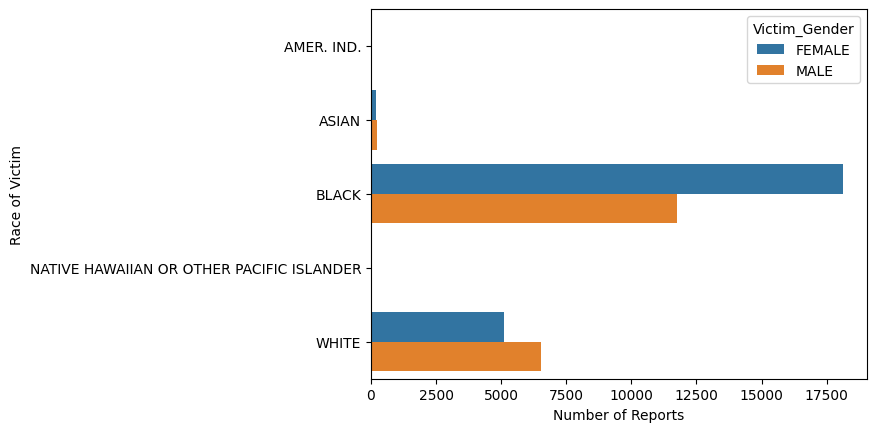

In [227]:
reports_by_race_gender = reports_with_victim_info.groupby(["Victim_Race", "Victim_Gender"]).size().reset_index(name="Number of Reports")
ax = sns.barplot(reports_by_race_gender, y="Victim_Race", x="Number of Reports", hue="Victim_Gender")
ax.set(ylabel = "Race of Victim")

We can see that black women make up an extremely high proportion of victims. However, we cannot see any data for American Indian or Naitive Hawaiian victims, so lets take the log and see if we can get a better look. This will compress the x axis so that we can view populations with very low counts on the same chart as populations with very high counts, but it does NOT change the actual data. This is purely for visualization.

[Text(0, 0.5, 'Race of Victim'), Text(0.5, 0, 'Number of Reports (log)')]

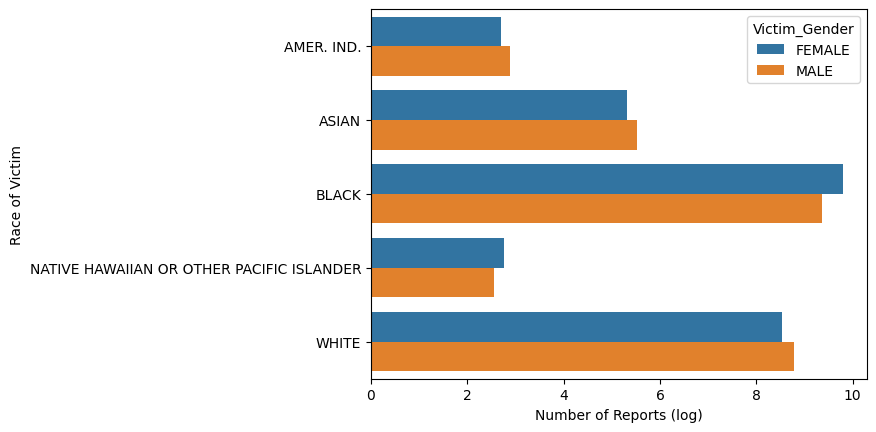

In [228]:
reports_by_race_gender["Number of Reports"] = reports_by_race_gender["Number of Reports"].apply(math.log)
ax = sns.barplot(reports_by_race_gender, y="Victim_Race", x="Number of Reports", hue="Victim_Gender")
ax.set(ylabel = "Race of Victim", xlabel= "Number of Reports (log)")

 Much better

Next we will group the data by month.

In [229]:
def isolate_year_month(entry):
    date_time_pattern = r"^\d{4}-(\d{2})-\d{2}\s\d{2}:\d{2}:\d{2}$" # Parentheses around the part of the pattern that will match the month
    return re.sub(date_time_pattern, r"\1", entry) # We use the first match to replace the entire string.

In [230]:
police_reports["Occurred_Date_Time"] = police_reports["Occurred_Date_Time"].apply(isolate_year_month)

**Note: Data is incomplete because it is from this year, but by the time project is turned in we should have almost a full year of data available**

[Text(0.5, 0, 'Month'), Text(0, 0.5, 'Number of Reports')]

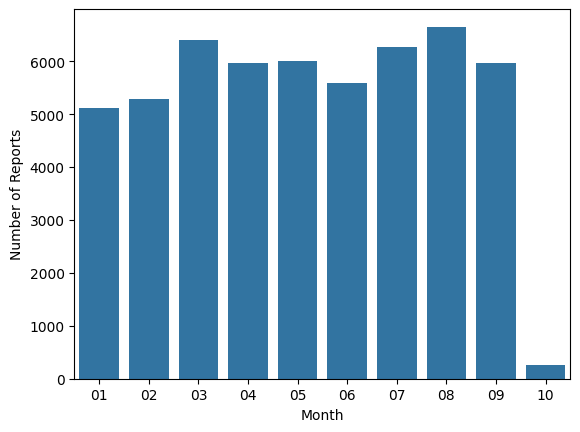

In [231]:
reports_by_month = police_reports.groupby("Occurred_Date_Time")
ax = sns.barplot(reports_by_month.size())
ax.set(xlabel="Month", ylabel="Number of Reports")

We can see two peaks, one in March and one in August. The full month that has the lowest number of reports is January.

Let's explore the data a bit more. We'll start by seeing how many reports were filed in each district.

In [232]:
reports_by_district = police_reports.groupby("District")
reports_by_district.size()

District
1     5748
2     5073
3     5992
4     4818
5     6922
6     6761
7    10357
8     7845
dtype: int64

We can make this into a bar chart to vizualize it better.

[Text(0, 0.5, 'Number of Reports')]

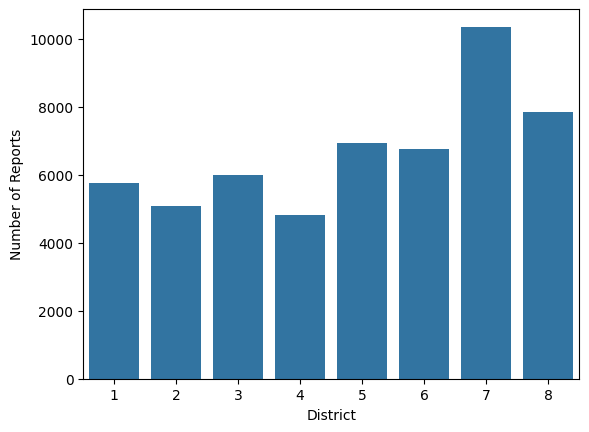

In [233]:
ax = sns.barplot(reports_by_district.size())
ax.set(ylabel="Number of Reports")

As we can see, the highest frequency of crime reports occurs in District 7. In future milestones we will explore why this might be and include an interactive map to display these statistics.

## Loading in a second data set (Milestone 2)
To get more context on police reports, we will load in our second dataset, **New Orleans Police Department Calls for Service 2025**

In [234]:
PATH_TO_CALLS_FOR_SERVICE = os.path.join(DATA_DIR, "Calls_for_Service_2025.csv")
calls_for_service = pd.read_csv(PATH_TO_CALLS_FOR_SERVICE)
calls_for_service.head()

,NOPD_Item,Type,TypeText,Priority,InitialType,InitialTypeText,InitialPriority,MapX,MapY,TimeCreate,...,TimeArrive,TimeClosed,Disposition,DispositionText,SelfInitiated,Beat,BLOCK_ADDRESS,Zip,PoliceDistrict,Location
0,B1105225,21J,MISSING JUVENILE,1,21J,MISSING JUVENILE,2F,37369000,3513814,2025-02-11T22:48:15.970000,...,2025-02-12T03:56:09.213000,2025-02-12T06:01:17.150000,RTF,REPORT TO FOLLOW,N,7D02,064XX Chestershire Dr,70126.0,7,POINT (0 0)
1,E1305925,52,SIMPLE ARSON,1D,21,COMPLAINT OTHER,1F,3669577,535978,2025-05-14T09:46:47.553000,...,2025-05-14T11:08:34.473000,2025-05-14T16:06:04.473000,RTF,REPORT TO FOLLOW,N,1K02,040XX Tulane Av,70119.0,1,POINT (-90.10556551 29.96811038)
2,F0608625,35D,SIMPLE BATTERY DOMESTIC,2C,103D,DOMESTIC DISTURBANCE,1A,3668911,532344,2025-06-06T22:16:37.057000,...,2025-06-08T08:13:39.363000,2025-06-08T11:08:07.127000,RTF,REPORT TO FOLLOW,N,2V03,032XX Bloomingdale Ct,70125.0,2,POINT (-90.10779393 29.9581383)
3,F0617425,103D,DOMESTIC DISTURBANCE,1A,103D,DOMESTIC DISTURBANCE,2C,3660638,531179,2025-06-07T00:58:44.983000,...,2025-06-08T05:12:11.927000,2025-06-08T05:55:23.387000,RTF,REPORT TO FOLLOW,N,2K02,015XX General Ogden St,70118.0,2,POINT (-90.13395361 29.95517682)
4,E1452725,103F,FIGHT,2D,35,SIMPLE BATTERY,2E,3679264,521299,2025-05-15T17:32:47.277000,...,2025-05-15T17:37:25.593000,2025-05-15T19:09:12.410000,RTF,REPORT TO FOLLOW,N,6A06,008XX Jackson Av,70130.0,6,POINT (-90.07548229 29.92745961)


Some quick descriptive statistics:

In [235]:
calls_for_service.describe()

,MapX,MapY,Zip,PoliceDistrict
count,2.517380e+05,2.517380e+05,247377.000000,251738.000000
mean,5.112833e+06,6.624243e+05,70120.833554,4.458493
std,6.876269e+06,6.092767e+05,5.847244,2.361602
min,0.000000e+00,-8.230700e+04,70112.000000,0.000000
25%,3.672900e+06,5.290650e+05,70116.000000,3.000000
50%,3.681228e+06,5.359010e+05,70119.000000,4.000000
75%,3.694436e+06,5.490160e+05,70126.000000,7.000000
max,3.736900e+07,3.513814e+06,70148.000000,8.000000


We can see that many of the categorical variables are being treated as nominal or ordinal values. Zipcode, PoliceDistrict, and map coordinates are numerical values, but performing operations on them is not meaninful. Lets convert them to objects. In fact, there are no variables where operations are meaningful, so we convert all columns to objects.

In [236]:
calls_for_service = calls_for_service.astype(object)
calls_for_service.dtypes

NOPD_Item          object
Type               object
TypeText           object
Priority           object
InitialType        object
InitialTypeText    object
InitialPriority    object
MapX               object
MapY               object
TimeCreate         object
TimeDispatch       object
TimeArrive         object
TimeClosed         object
Disposition        object
DispositionText    object
SelfInitiated      object
Beat               object
BLOCK_ADDRESS      object
Zip                object
PoliceDistrict     object
Location           object
dtype: object

Let's clean the data. For the purposes of our analysis, we will only need the following variables:
- TypeText (the type of crime)
- BLOCK_ADDRESS
- TimeCreate (just to get the month)
- PoliceDistrict

In [237]:
columns_to_drop = ['NOPD_Item', 'TypeText', 'Priority',
                   'InitialType', 'InitialTypeText', 'InitialPriority',
                    'TimeDispatch', 'TimeArrive',
                   'TimeClosed', 'Disposition', 'DispositionText',
                   'SelfInitiated', 'Beat', 'Location', 'MapX', 'MapY', "Zip"]

clean_calls_for_service = calls_for_service.drop(columns=columns_to_drop, axis=1)
clean_calls_for_service = clean_calls_for_service.drop(clean_calls_for_service.loc[clean_calls_for_service["PoliceDistrict"] == 0].index)
clean_calls_for_service = clean_calls_for_service[["PoliceDistrict", "BLOCK_ADDRESS", "Type", "TimeCreate"]]

clean_calls_for_service.head()

,PoliceDistrict,BLOCK_ADDRESS,Type,TimeCreate
0,7,064XX Chestershire Dr,21J,2025-02-11T22:48:15.970000
1,1,040XX Tulane Av,52,2025-05-14T09:46:47.553000
2,2,032XX Bloomingdale Ct,35D,2025-06-06T22:16:37.057000
3,2,015XX General Ogden St,103D,2025-06-07T00:58:44.983000
4,6,008XX Jackson Av,103F,2025-05-15T17:32:47.277000


We also want the TimeCreate column to only show the date, so lets edit our regular expression to extract just the month like we did in our other dataset:


In [238]:
def isolate_year_month_2(entry):
    pattern = r"^\d{4}-(\d{2})-\d{2}T\d{2}:\d{2}:\d{2}\.\d+$"
    return re.sub(pattern, r"\1", entry)

clean_calls_for_service["TimeCreate"] = clean_calls_for_service["TimeCreate"].apply(isolate_year_month_2)
clean_calls_for_service.head()
police_reports.head()

,District,Location,Signal_Type,Occurred_Date_Time
0,5,014XX Montegut St,62C,08
1,5,014XX Montegut St,62C,08
6,5,015XX Alvar St,103,07
9,4,029XX Hudson St,103D,08
10,4,029XX Hudson St,103D,08


Now let's rename the columns to be the same as our other dataset:

In [239]:
clean_calls_for_service = clean_calls_for_service.rename(columns={"PoliceDistrict":"District", "BLOCK_ADDRESS":"Location", "Type":"Signal_Type", "TimeCreate":"Occurred_Date_Time"})
clean_calls_for_service.head()

,District,Location,Signal_Type,Occurred_Date_Time
0,7,064XX Chestershire Dr,21J,02
1,1,040XX Tulane Av,52,05
2,2,032XX Bloomingdale Ct,35D,06
3,2,015XX General Ogden St,103D,06
4,6,008XX Jackson Av,103F,05


Now that our two datasets have the same structures, let's combine them into a single dataframe. 

In [240]:
calls_and_reports = pd.concat([police_reports, clean_calls_for_service], ignore_index=True)


print(f'Shape of first dataframe: {police_reports.shape}\n')
print(f'Shape of first dataframe: {clean_calls_for_service.shape}\n')
print(f'Shape of COMBINED dataframe: {calls_and_reports.shape}')



Shape of first dataframe: (53516, 4)

Shape of first dataframe: (249091, 4)

Shape of COMBINED dataframe: (302607, 4)


Now lets use a third dataset to assign each of the signal types ("crime codes") to a readable crime description that are consistent between datasets. This dataset was sourced from [here](https://nola.gov/nola/media/NOPD/Policies/Chapter-81-7-Police-Complaint-Signals-and-Dispositions-EFFECTIVE-1-14-18.pdf), and maps each crime signal to plain english text of the crime. Since this is a PDF, we had AI parse through the document and create a CSV file that pandas can read. 


In [241]:
PATH_TO_SIGNALS = os.path.join(DATA_DIR, "crime_signal_codes.csv")
signals = pd.read_csv(PATH_TO_SIGNALS)
signals.head()

,Signal,Description
0,15,CITIZEN HOLDING A SUSPECT
1,17F,FUGITIVE ATTACHMENT
2,17J,JUVENILE ATTACHMENT
3,17M,MUNICIPAL COURT ATTACHMENT
4,17R,WARRANT STOP AND RELEASE


In [242]:
# create a mapping 
lookup = dict(zip(signals["Signal"], signals["Description"]))

# apply mapping
calls_and_reports["SignalDescription"] = calls_and_reports["Signal_Type"].map(lookup)

# rename columns for consistency
calls_and_reports = calls_and_reports.rename(columns={"SignalDescription":"Signal_Description", "Occurred_Date_Time":"Occurred_Month"})

# reorganize columns
calls_and_reports = calls_and_reports[["District", "Location", "Signal_Type", "Signal_Description", "Occurred_Month"]]

# drop duplicate entries (same reports)
calls_and_reports = calls_and_reports.drop_duplicates().reset_index(drop=True)
calls_and_reports.head()



,District,Location,Signal_Type,Signal_Description,Occurred_Month
0,5,014XX Montegut St,62C,"SIMPLE BURGLARY, AUTO",08
1,5,015XX Alvar St,103,DISTURBANCE,07
2,4,029XX Hudson St,103D,"DISTURBANCE, DOMESTIC",08
3,6,026XX S Galvez St,21,COMPLAINT,08
4,8,009XX Canal St,67A,AUTO THEFT,08


Now that we have this dataframe, lets try to get a bit more information about the districts we are talking about. Unfortunately, our police data is divided by police districts, while most available data is divided by zip code. However, we can create a rough mapping of zip codes to district. While it is not perfect, most police district boundaries are also zip code boundaries.

The zip code data can be found [here](https://localistica.com/usa/la/new%20orleans/zipcodes/most-populated-zipcodes/).

First, we will retrieve the zip code data using requests and beautifulsoup

In [243]:
import requests
from bs4 import BeautifulSoup
from io import StringIO

r = requests.get("https://localistica.com/usa/la/new%20orleans/zipcodes/most-populated-zipcodes/")

We'll go ahead and save the content to a file since the website could go down or the data could become unavailable in the future. Once the content is downloaded, we will comment out the code we used to download the content to prevent overwriting the file in the future.

In [244]:
#with open("data/zipCodeRequestContent.txt", "w", encoding="utf-8") as f:
#    f.write(str(r.content))

Now we will reopen the file and read its contents and use BeautifulSoup to parse the content as we normally did in class.

In [245]:
with open("data/zipCodeRequestContent.txt") as f:
    content = f.read()

soup = BeautifulSoup(content)

We'll use beautifulsoup's find_all() function to isolate the table we want.

In [246]:
table = soup.find_all("table")

# Remove escape characters from text
clean_html = str(table).replace("\\r", "").replace("\\n", "").replace("\\t", "")

# Wrap in StringIO object to prevent error from pandas
clean_html = StringIO(clean_html)

# Read into dataframe using html, set header = 0 so our column titles are headers.
zipTable = pd.read_html(clean_html, header=0)[0].drop("City", axis=1)

In [247]:
zipTable

,ZipCode,Population,Growth,Age,Income per household
0,70119,39886.0,9%,34.2,"$21,297.00"
1,70115,35705.0,11%,36.6,"$27,094.00"
2,70122,33995.0,15%,36.9,"$31,104.00"
3,70118,33333.0,0%,30.0,"$28,006.00"
4,70117,30675.0,23%,37.6,"$19,567.00"
5,70126,28889.0,17%,32.4,"$30,627.00"
6,70131,28495.0,-4%,35.7,"$45,592.00"
7,70123,28303.0,6%,43.1,"$45,596.00"
8,70114,26655.0,14%,34.7,"$23,379.00"
9,70127,24481.0,16%,30.6,"$30,954.00"


Looks okay, but we can drop the unused rows

In [248]:
unusedCols = range(19,24)
zipTable = zipTable.drop(unusedCols)

In [249]:
zipTable

,ZipCode,Population,Growth,Age,Income per household
0,70119,39886.0,9%,34.2,"$21,297.00"
1,70115,35705.0,11%,36.6,"$27,094.00"
2,70122,33995.0,15%,36.9,"$31,104.00"
3,70118,33333.0,0%,30.0,"$28,006.00"
4,70117,30675.0,23%,37.6,"$19,567.00"
5,70126,28889.0,17%,32.4,"$30,627.00"
6,70131,28495.0,-4%,35.7,"$45,592.00"
7,70123,28303.0,6%,43.1,"$45,596.00"
8,70114,26655.0,14%,34.7,"$23,379.00"
9,70127,24481.0,16%,30.6,"$30,954.00"


Now we will match districts with zip code. Although this is not perfect, it lines up reasonably well for our puposes.
The Police Districts map can be found [here](https://nola.gov/next/nopd/about/police-districts/). This map was cross referenced with a map of New Orleans zip codes.

In [250]:
districtToZip = {1: [70119], 2: [70118, 70125], 3: [70124, 70122], 4: [70114, 70131], 5:[70117, 70126], 6:[70115, 70113, 70130], 7:[70127, 70128, 70129], 8:[70116,70112]}

In [251]:
# Create a dictionary that maps each zip code to its district so that we can apply it to our table
zipToDistrict = {
    zip_code: district
    for district, zips in districtToZip.items()
    for zip_code in zips
}


Let's clean up the data, we need to add the district column, remove a few rows, and format and correctly type some of the columns. All operations are explained in comments

In [252]:
# Use map to apply our dictionary to every value in the zipcode column and create a new column for district
zipTable["District"] = zipTable["ZipCode"].map(zipToDistrict)

# 70123 and 70121 are in Jefferson and are not covered by an NOPD district, so we will drop them
zipTable = zipTable.drop(zipTable.loc[(zipTable["ZipCode"] == 70123)].index)
zipTable = zipTable.drop(zipTable.loc[(zipTable["ZipCode"] == 70121)].index)

# convert district to integers
zipTable = zipTable.astype({'District': 'int32', 'Population': 'int32'})

# extract growth percentages and convert them to floating point numbers out of 100
zipTable["Growth"] = zipTable["Growth"].str.extract(f'(-?[0-9]+)').astype(float) / 100

# Extract income per household from string and convert to floating point
zipTable["Income per household"] = zipTable["Income per household"].str.extract('((?:[0-9]+,)?[0-9]+.[0-9]+)')
zipTable["Income per household"] = zipTable["Income per household"].str.replace(',', '').astype(float)

# To weight income per household by population in the next step
zipTable["Weighted Income per Household"] = zipTable["Income per household"] * zipTable["Population"]


Let's look at our newly cleaned dataframe and its types

In [253]:
zipTable

,ZipCode,Population,Growth,Age,Income per household,District,Weighted Income per Household
0,70119,39886,0.09,34.2,21297.0,1,8.494521e+08
1,70115,35705,0.11,36.6,27094.0,6,9.673913e+08
2,70122,33995,0.15,36.9,31104.0,3,1.057380e+09
3,70118,33333,0.00,30.0,28006.0,2,9.335240e+08
4,70117,30675,0.23,37.6,19567.0,5,6.002177e+08
5,70126,28889,0.17,32.4,30627.0,5,8.847834e+08
6,70131,28495,-0.04,35.7,45592.0,4,1.299144e+09
8,70114,26655,0.14,34.7,23379.0,4,6.231672e+08
9,70127,24481,0.16,30.6,30954.0,7,7.577849e+08
10,70124,19561,0.13,36.9,51684.0,3,1.010991e+09


In [254]:
zipTable.dtypes

ZipCode                            int64
Population                         int32
Growth                           float64
Age                              float64
Income per household             float64
District                           int32
Weighted Income per Household    float64
dtype: object

Now that this table is clean, we can group our table by district and scale some of the features by population to get a more holistic look at each district

In [255]:
districtGroupby = zipTable.groupby("District")

In [256]:
# The columns we will want to use
pop = districtGroupby['Population'].sum()
growth = districtGroupby['Growth'].mean().round(2)
age = districtGroupby['Age'].mean().round(2)

# Calculating the income per household weighted by population of each zip code, include_groups = False silences warning and gives same result
income = districtGroupby.apply(lambda x: x["Weighted Income per Household"].sum() / x["Population"].sum(), include_groups=False).round(2)
income.name = "Income per Household"

# Join these series together to get one districts dataframe
dfDistricts = pd.concat([pop, age, growth, income], axis = 1).reset_index()

# rename growth for clarity
dfDistricts = dfDistricts.rename(columns={"Growth":"Population_Growth"})

Great! Now we have more data to work with, and we can use this quantitative data to help develop a model, an aspect which we were missing in Milestone 1.

Here is all of the data we have so far:

In [257]:
display(dfDistricts)
display(calls_and_reports)

,District,Population,Age,Population_Growth,Income per Household
0,1,39886,34.20,0.09,21297.00
1,2,49134,30.50,0.04,25459.97
2,3,53556,36.90,0.14,38620.72
3,4,55150,35.20,0.05,34856.05
4,5,59564,35.00,0.20,24931.19
5,6,60855,36.97,0.14,24839.29
6,7,54108,32.57,0.13,35092.83
7,8,18511,37.35,0.20,17408.99


,District,Location,Signal_Type,Signal_Description,Occurred_Month
0,5,014XX Montegut St,62C,"SIMPLE BURGLARY, AUTO",08
1,5,015XX Alvar St,103,DISTURBANCE,07
2,4,029XX Hudson St,103D,"DISTURBANCE, DOMESTIC",08
3,6,026XX S Galvez St,21,COMPLAINT,08
4,8,009XX Canal St,67A,AUTO THEFT,08
...,...,...,...,...,...
182776,6,S Claiborne Av & Josephine St,20I,INJURY ACCIDENT,08
182777,1,006XX Blk S Telemachus St,21,COMPLAINT,08
182778,5,St Roch Av & N Villere St,21,COMPLAINT,08
182779,5,020XX Blk Louisa St,21,COMPLAINT,08


In [258]:
calls_and_reports["District"].value_counts()

District
3    31242
7    27159
8    23390
6    23075
1    22784
5    22248
2    17309
4    15574
Name: count, dtype: int64

### Exploratory Data Analysis

Let's delve deeper into the data that we have.

First, let's add a new column to the District Data table that has the total number of reports in each district.

In [259]:
reportCountByDistrict = calls_and_reports.groupby("District")["Location"].count()

In [260]:
dfDistricts = dfDistricts.merge(reportCountByDistrict, on="District")
dfDistricts = dfDistricts.rename(columns={"Location": "NumReports"})

In [261]:
dfDistricts 

,District,Population,Age,Population_Growth,Income per Household,NumReports
0,1,39886,34.20,0.09,21297.00,22784
1,2,49134,30.50,0.04,25459.97,17309
2,3,53556,36.90,0.14,38620.72,31242
3,4,55150,35.20,0.05,34856.05,15574
4,5,59564,35.00,0.20,24931.19,22248
5,6,60855,36.97,0.14,24839.29,23075
6,7,54108,32.57,0.13,35092.83,27159
7,8,18511,37.35,0.20,17408.99,23390


Let's get some basic summary statistics:

In [280]:
dfDistricts.describe().T

,count,mean,std,min,25%,50%,75%,max
District,8.0,4.50000,2.449490,1.00,2.7500,4.500,6.2500,8.00
Population,8.0,48845.50000,13883.605604,18511.00,46822.0000,53832.000,56253.5000,60855.00
Age,8.0,34.83625,2.379489,30.50,33.7925,35.100,36.9175,37.35
Population_Growth,8.0,0.12375,0.060695,0.04,0.0800,0.135,0.1550,0.20
Income per Household,8.0,27813.25500,7490.884933,17408.99,23953.7175,25195.580,34915.2450,38620.72
NumReports,8.0,22847.62500,4976.300144,15574.00,21013.2500,22929.500,24332.2500,31242.00


### Income v. Number of Reports by District

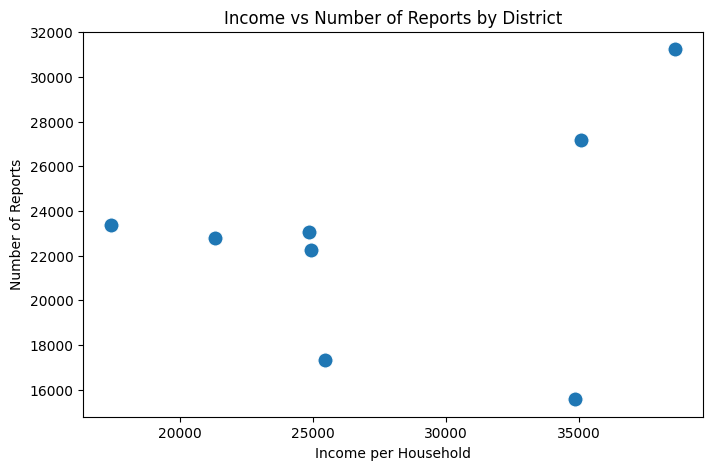

In [265]:
plt.figure(figsize=(8,5))
sns.scatterplot(dfDistricts, x="Income per Household", y="NumReports", s=120)
plt.title("Income vs Number of Reports by District")
plt.xlabel("Income per Household")
plt.ylabel("Number of Reports")
plt.show()

### Population Growth by District

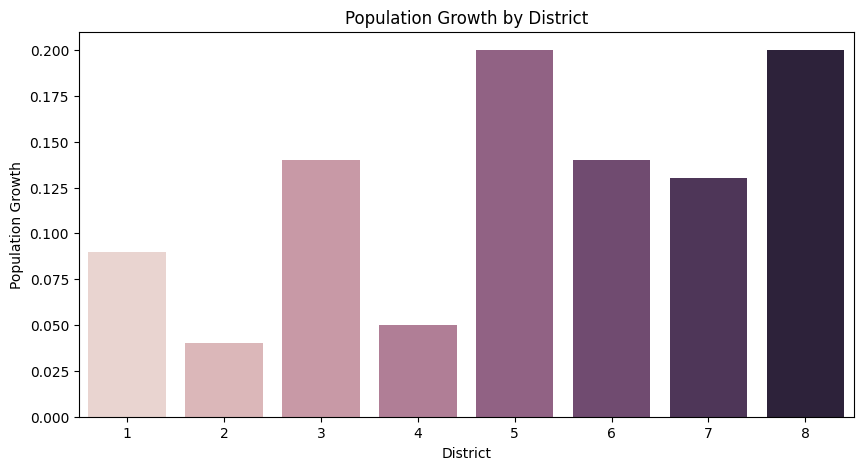

In [276]:
plt.figure(figsize=(10,5))
sns.barplot(dfDistricts, x="District", y="Population_Growth", hue="District", legend=False)
plt.title("Population Growth by District")
plt.ylabel("Population Growth")
plt.show()

### Correlation Heatmap of District Metrics

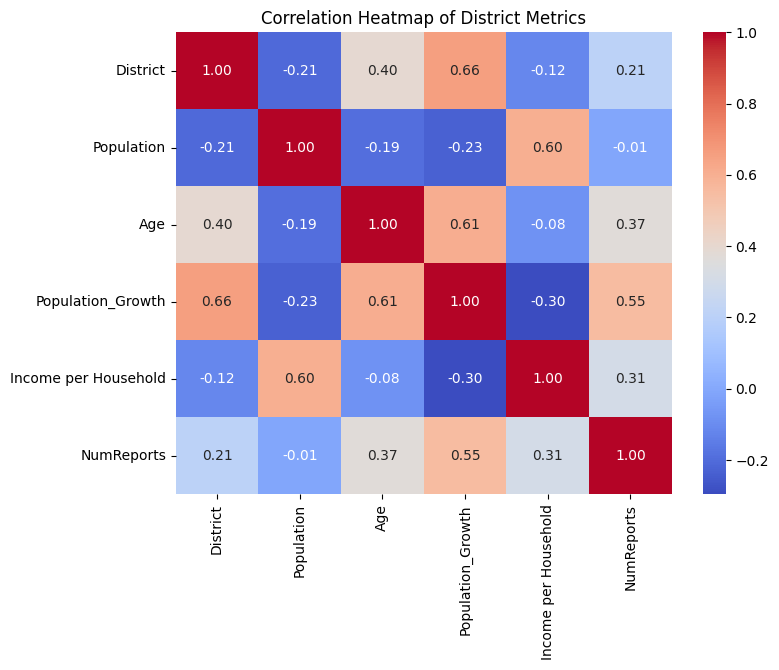

In [283]:
plt.figure(figsize=(8,6))
sns.heatmap(dfDistricts.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of District Metrics")
plt.show()

### Population Growth vs. Number of Reports

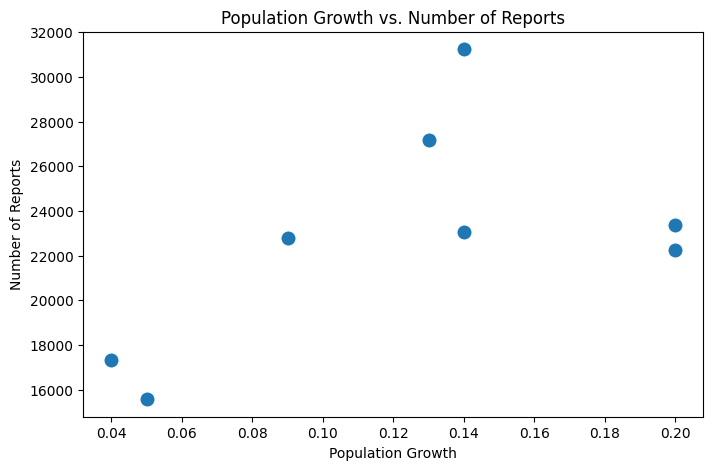

In [275]:
plt.figure(figsize=(8,5))
sns.scatterplot(dfDistricts, x="Population_Growth", y="NumReports", s=120)
plt.title("Population Growth vs. Number of Reports")
plt.xlabel("Population Growth")
plt.ylabel("Number of Reports")
plt.show()

### Cross Tabulation of Population Growth and Income per Household

In [286]:
Growth = pd.cut(
    dfDistricts["Population_Growth"],
    bins=[-1, 0.05, 0.15, 0.30],
    labels=["Low Growth", "Medium Growth", "High Growth"]
)

Income = pd.cut(
    dfDistricts["Income per Household"],
    bins=[0, 20000, 30000, 40000],
    labels=["Low", "Mid", "High"]
)

pd.crosstab(Growth, Income)

Income per Household,Low,Mid,High
Population_Growth,,,
Low Growth,0,1,1
Medium Growth,0,2,2
High Growth,1,1,0


### Model Plan

Now that we have all of our data loaded, cleaned, and combined, we will discuss two plausible models we can build using our data.

1. **Predict income (label) based on the features of average age, population, and total number of crimes per district.**

    - We more generally want to create a model to explore the relationship between income and the prevalency of crime.

--------------

2. **Predict signal description (label) by using all available features (district, population, age, growth, income, number of crimes per district, etc.)**

    - Due to the fact that there are 165 different crime signals, we might have to combine similar crimes to make an effective model.